# Histopathologic Cancer Detection


In [107]:
import re
import os
import random
import numpy as np
import pandas as pd
import shutil

import random
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from keras import layers
from keras.utils import to_categorical

In [100]:
tf.__version__

'2.10.1'

In [101]:
print(os.listdir())

['.git', '.gitattributes', '.ipynb_checkpoints', '.vscode', 'cancer_model.keras', 'histopathologic-cancer-detection.ipynb', 'model_dir', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'train_labels.csv']


In [102]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analaysis](#paragraph1)
3. [Model Architecture](#paragraph2)
4. [Results & Analaysis](#paragraph3)
5. [References](#references)

## 1. Introduction <a name="introduction"></a>

From https://www.kaggle.com/competitions/histopathologic-cancer-detection:

> In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

> The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In summary, this is a binary image classification problem where we train the model to label whether a tissue sample has cancer or not.

## 2. Exploratory Data Analysis <a name="paragraph1"></a>

In [ ]:
labels  = pd.read_csv('train_labels.csv')

df = pd.DataFrame({'path': glob(os.path.join('train','*.tif'))})
df['id'] = df['path'].map(lambda x: x.split('\\')[1].split('.')[0])
data = df.merge(labels, on = "id")

data.head()

,path,id,label
0,train\00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,train\000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,train\00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,train\0000da768d06b879e5754c43e2298ce48726f722...,0000da768d06b879e5754c43e2298ce48726f722,1


In [ ]:
print(data.shape)
data.groupby('label').count()

(220025, 3)
(57458, 1)


,path,id
label,,
0,130908,130908
1,89117,89117


In [ ]:
n = 80000 #trying to save memory/runtime

data0 = data[data['label'] == 0].sample(n, random_state = 0)
data1 = data[data['label'] == 1].sample(n, random_state = 0)

sample = pd.concat([data0, data1], axis = 0).reset_index(drop=True)

sample.head()

,path,id,label
0,train\d552c8409854335d28445510afeb4739bfcb3a15...,d552c8409854335d28445510afeb4739bfcb3a15,0
1,train\57744c206b2997eb2e86fa5dbdfd65a9b6f53eab...,57744c206b2997eb2e86fa5dbdfd65a9b6f53eab,0
2,train\01f623b9aecc4f0f55154d046a926ecf4e43ff0f...,01f623b9aecc4f0f55154d046a926ecf4e43ff0f,0
3,train\f859b77e3fec6ac7804734822dbae1191b877bae...,f859b77e3fec6ac7804734822dbae1191b877bae,0
4,train\2c53829da058a41261df9c1ec6a142bca8f66fec...,2c53829da058a41261df9c1ec6a142bca8f66fec,0


### Visualization of Data

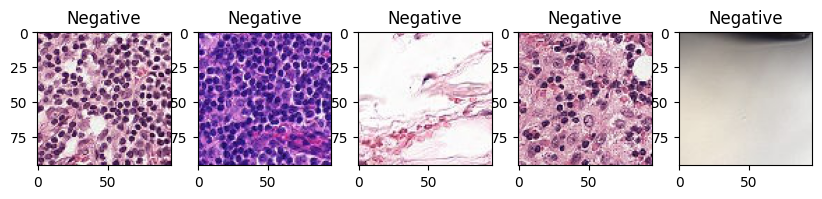

In [ ]:
negative_sample = sample[sample['label'] == 0].sample(5, random_state = 0).reset_index(drop=True)

plt.figure(figsize = (10,10))
for n in range(5):
    path = os.path.join('./', negative_sample.loc[n].at['path'])
    ax = plt.subplot(1,5,n+1)
    im = plt.imread(path) #'./train/5ce750ac3940dddcbab7b91febf5f75a261b2ad6.tif'
    plt.title("Negative")
    plt.imshow(im)

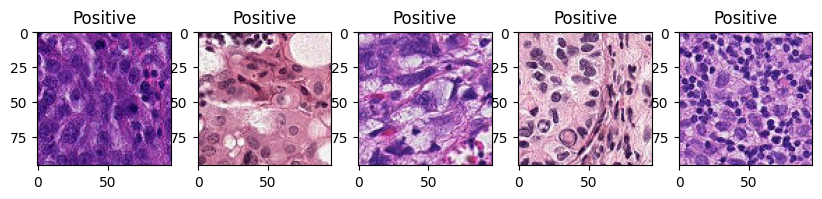

In [ ]:
positive_sample = sample[sample['label'] == 1].sample(5, random_state = 0).reset_index(drop=True)
plt.figure(figsize = (10,10))
for n in range(5):
    path = os.path.join('./', positive_sample.loc[n].at['path'])
    ax = plt.subplot(1,5,n+1)
    im = plt.imread(path) #'./train/5ce750ac3940dddcbab7b91febf5f75a261b2ad6.tif'
    plt.title("Positive")
    plt.imshow(im)

The percent of positive results are: % 40.5


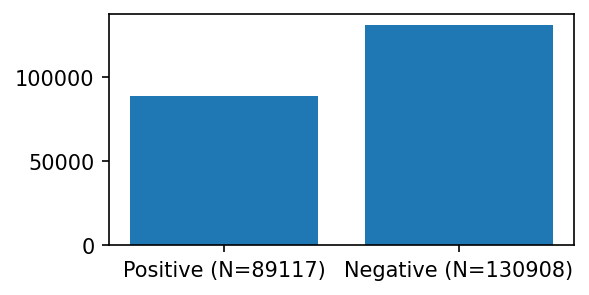

In [ ]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(data['label']==0).sum(), (data['label']==1).sum()]); 
plt.xticks([1,0],["Negative (N={})".format((data['label']==0).sum()),"Positive (N={})".format((data['label']==1).sum())]);
print("The percent of positive results are: %", 100*round(89117/len(data),3))

A naive algorithm would be able to be up to `60%` accurate just by guessing that a particular image doesn't have cancer.

### Train-Validation Set Split

In [ ]:
X_train, X_val = train_test_split(sample, test_size = 0.10, stratify = sample['label'])

print(X_train.shape)
print(X_val.shape)

(144000, 3)
(16000, 3)


In [ ]:
X_train.groupby('label').count()

,path,id
label,,
0,72000,72000
1,72000,72000


In [ ]:
X_val.groupby('label').count()

,path,id
label,,
0,8000,8000
1,8000,8000


### Directory Management

In [ ]:
model_dir = 'model_dir'
train_dir = os.path.join(model_dir, 'train_dir')
val_dir = os.path.join(model_dir, 'val_dir')
tumor_negative_train = os.path.join(train_dir, 'tumor_negative')
tumor_negative_val = os.path.join(val_dir, 'tumor_negative')
tumor_positive_train = os.path.join(train_dir, 'tumor_positive')
tumor_positive_val = os.path.join(val_dir, 'tumor_positive')

os.makedirs(tumor_negative_train, exist_ok = True)
os.makedirs(tumor_negative_val, exist_ok = True)
os.makedirs(tumor_positive_train, exist_ok = True)
os.makedirs(tumor_positive_val, exist_ok = True)
os.listdir(train_dir)

train_list = list(X_train['id'])
val_list = list(X_val['id'])

data.set_index('id', inplace=True)

In [ ]:
for image in train_list:
    fname = image + '.tif'
    target = data.loc[image,'label']
    
    if target == 0: label = 'tumor_negative'
    if target == 1: label = 'tumor_positive'
    
    src = os.path.join('./train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

In [ ]:
for image in val_list:
    fname = image + '.tif'
    target = data.loc[image,'label']
    
    if target == 0: label = 'tumor_negative'
    if target == 1: label = 'tumor_positive'
    
    src = os.path.join('./train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)
    

In [ ]:
print(len(os.listdir('model_dir/train_dir/tumor_negative')))
print(len(os.listdir('model_dir/train_dir/tumor_positive')))

print(len(os.listdir('model_dir/val_dir/tumor_negative')))
print(len(os.listdir('model_dir/val_dir/tumor_positive')))

72000
72000
8000
8000


## 3. Model Architecture <a name="paragraph2"></a>

### Image Generator
Setting up batch processing - these image generators preprocess the data by normalizing the data. This hopefully will allow us to generalize our model to the test set.

In [ ]:
IMAGE_SIZE = 96
num_train_samples = len(X_train)
num_val_samples = len(X_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(val_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

test_gen = datagen.flow_from_directory(val_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)



Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Set up Model

Model inspiration taken from the keras documentation on Pneumonia x-ray classification with modifications for this project (32x32 px center filter).

https://keras.io/examples/vision/xray_classification_with_tpus/


* Input Layer
* Convolutional Layer 1 (Convolution > MaxPool), filters = 16
* Covolutional Layers 2-5 (Convolutions w/ filters = 32, 64, 128, 256 --> Batch Normalization --> Dropout)
* Flatten
* Dense (512 --> 128 --> 64 nodes)
* Output

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
dropout_rate = 0.3

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D(pool_size = (2,2))(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, kernel_size, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, kernel_size, activation="relu", padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPool2D(pool_size= (2,2))(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(dropout_rate)(x)

    x = conv_block(256, x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x) #binary output layer

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
#save model so we dont have to retrain
checkpoint_cb = keras.callbacks.ModelCheckpoint("cancer_model.keras", save_best_only=True) 

#early_stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5, verbose = 1,
    restore_best_weights=True
)

#reduce learning rate if gradient plateaus
reducel = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

model = build_model()

#learning rate scheduling, not necessary with Adam optimization 
'''
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True #exponential decay learning rate
)'''

mets = [ 
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(Adam(learning_rate = 0.01), loss = "binary_crossentropy", metrics=mets)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 dropout_12 (Dropout)        (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                           

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=13,
                   callbacks=[checkpoint_cb, reducel, early_stopping_cb])

C:\Users\Michael Christensen\AppData\Local\Temp\ipykernel_10576\2923463345.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/13
4500/4500 [==============================] - 724s 161ms/step - loss: 0.5178 - binary_accuracy: 0.7504 - precision: 0.7541 - recall: 0.7431 - val_loss: 2.0495 - val_binary_accuracy: 0.5002 - val_precision: 1.0000 - val_recall: 5.0000e-04 - lr: 0.0100
Epoch 2/13
4500/4500 [==============================] - ETA: 0s - loss: 0.4721 - binary_accuracy: 0.7829 - precision: 0.7907 - recall: 0.7695
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4500/4500 [==============================] - 689s 153ms/step - loss: 0.4721 - binary_accuracy: 0.7829 - precision: 0.7907 - recall: 0.7695 - val_loss: 2.5780 - val_binary_accuracy: 0.4997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 3/13
4500/4500 [==============================] - 600s 133ms/step - loss: 0.3991 - binary_accuracy: 0.8238 - precision: 0.8255 - recall: 0.8212 - val_loss: 0.8727 - val_binary_accuracy: 0.6423 - val_precision: 0.8489 - val_recall: 0.3462 - lr: 1.0000e-03
Epoch 

# 4. Results & Analysis <a name="paragraph3"></a>

At the end of our training, we had a binary accuracy of about `0.8` and an AUC of about `0.853`, which is a significant improvement over a naive model (e.g. a model that guessed negative every time would be accuracy `60%` of the time). We do have a way to go with out precision and recall - most cancer images are correctly identified but we also have a significant amount of false positives. We can also see how our metrics improved over epochs until they eventually plateau and trigger early stopping.

In [ ]:
model.evaluate(val_gen, return_dict=True)

500/500 [==============================] - 15s 29ms/step - loss: 0.4586 - binary_accuracy: 0.7969 - precision: 0.7714 - recall: 0.8439


{'loss': 0.458594411611557,
 'binary_accuracy': 0.796875,
 'precision': 0.771366536617279,
 'recall': 0.843874990940094}

In [ ]:
pred = model.predict_generator(test_gen, steps=len(X_val), verbose=1)
fpr, tpr, thresholds = roc_curve(test_gen.classes, pred)

   18/16000 [..............................] - ETA: 1:42

C:\Users\Michael Christensen\AppData\Local\Temp\ipykernel_10576\3970503428.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_gen, steps=len(X_val), verbose=1)


16000/16000 [==============================] - 42s 3ms/step


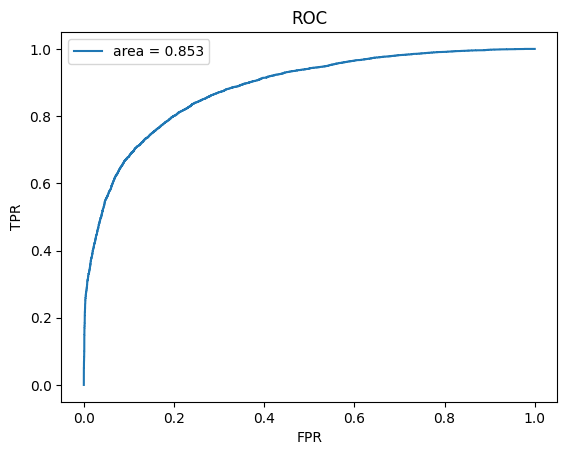

In [ ]:
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()

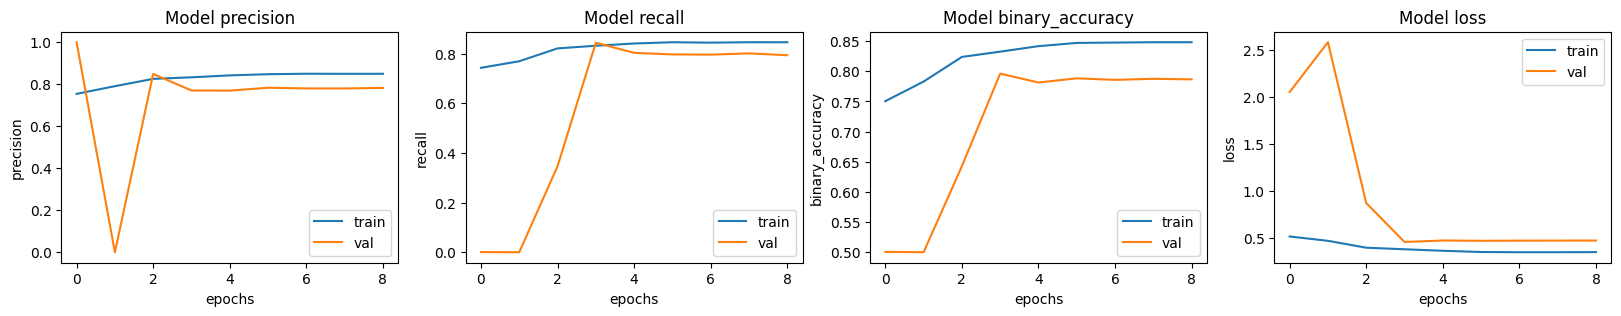

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [118]:
cm = confusion_matrix(test_gen.classes, pred.argmax(axis=1))

print(test_gen.classes)
print(pred)
print(cm)

[0 0 0 ... 1 1 1]
[[0.01638702]
 [0.7397154 ]
 [0.12694204]
 ...
 [0.9095577 ]
 [0.94678503]
 [0.7095992 ]]
[[8000    0]
 [8000    0]]


### Test Submission

We need to normalize our test set similar to how we used a generator for the training and validation set before predicting our labels. This is a bit finicky but we have forced the generator to read a single category. The caveat is that we may have to submit twice in case the predictions are flipped since the predictor is unlabeled.

In [155]:
test = pd.DataFrame({'path': glob(os.path.join('test\\test_dir','*.tif'))})

test.head()

,path
0,test\test_dir\00006537328c33e284c973d7b39d3408...
1,test\test_dir\0000ec92553fda4ce39889f9226ace43...
2,test\test_dir\00024a6dee61f12f7856b0fc6be20bc7...
3,test\test_dir\000253dfaa0be9d0d100283b22284ab2...
4,test\test_dir\000270442cc15af719583a8172c87cd2...


In [158]:
test_gen = datagen.flow_from_directory('.',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        classes=['test'], #pulls from a single "category"
                                        shuffle=False)


Found 57458 images belonging to 1 classes.


In [162]:
n_test = len(os.listdir('test\\test_dir'))

In [170]:
predictions = model.predict_generator(test_gen, steps = n_test, verbose = 1)


    1/57458 [..............................] - ETA: 1:27:08

C:\Users\Michael Christensen\AppData\Local\Temp\ipykernel_10576\3530390999.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps = n_test, verbose = 1)


57458/57458 [==============================] - 417s 7ms/step


In [177]:
submission = pd.DataFrame(predictions, columns=['label'])
submission.head()


,label
0,0.892489
1,0.634061
2,0.600279
3,0.016894
4,0.021564


In [ ]:
submission['path'] = test_gen.filenames
submission['id'] = submission['path'].map(lambda x: x.split('\\')[2].split('.')[0])


In [182]:
submission = submission.set_index('id')
submission = submission.drop(['path'], axis = 1)
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.892489
0000ec92553fda4ce39889f9226ace43cae3364e,0.634061
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.600279
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.016894
000270442cc15af719583a8172c87cd2bd9c7746,0.021564


In [184]:
submission.to_csv("submission.csv", header = True)


Our submission accuracy yielded `.8078` for the private score and `0.8744` for the public score.